Ensemble Learning: aggregating a group of algorithms to get a prediction
* works best when the predictors are as independent from one another as possible

### Voting Classifiers
aggregate a group of classifiers and predict the class that gets the most votes (hard voting)
* if each classifier is a weak learner, the ensemble can still be a strong learner, if there are a sufficient number of waek learners and they are sufficiently diverse
* weak learner: performs only slightly better than random guessing

In [ ]:
# Generating data and splitting it into train and test

## Imports
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

## Making moons
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)

## Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
# Implementing Voting Classifier

## Imports
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

## Creating objects
log_clf = LogisticRegression()
rf_clf = RandomForestClassifier()
svm_clf = SVC()

## Creating the Voting Classifier
voting_clf = VotingClassifier(
    estimators=[
      ('lr', log_clf), 
      ('rf', rf_clf), 
      ('svc', svm_clf)
    ],
    voting='hard'
)

## Fitting the voting classifier
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                             

In [ ]:
# Viewing the performance

from sklearn.metrics import accuracy_score
for clf in (log_clf, rf_clf, svm_clf, voting_clf):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.904


soft voting: average the probability of all the classifiers and chose the highest class probability
* gives more weight to the highly confident votes (often achieves higher performance than hard voting)
* set the ***voting*** parameter to "soft"

## Bagging and Pasting
two ways to get diverse classifiers:
* use very different training algorithms
* use same training algorithm but train them on different random subsets of the training set


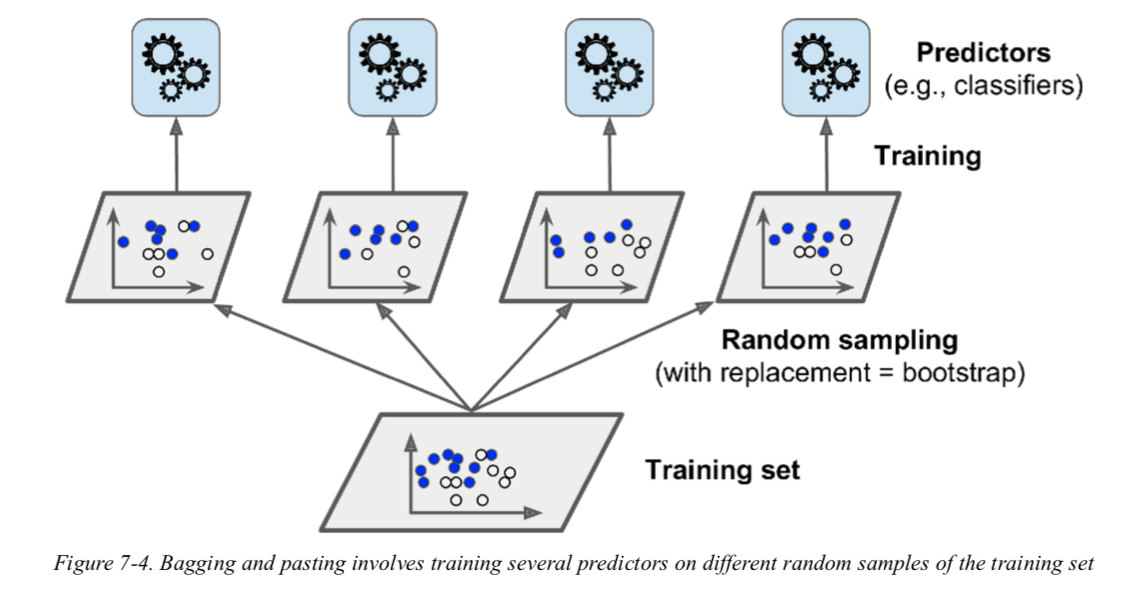

* bagging: sampling with replacement
* pasting: sampling without replacement
* ensemble makes prediction by aggregating the predictions of all predictors (mode: classification; average: regression)
* aggregation reduces both bias and variance

In [ ]:
# Implementing Bagging

## Imports
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

## Creating Bagging object
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=500,
    max_samples=100,
    bootstrap=True,
    n_jobs=-1
)

## Fitting the bagging classifier
bag_clf.fit(X_train, y_train)

## Predictign on the test data
y_pred = bag_clf.predict(X_test)

In [ ]:
# Creating a decision tree classifier for comparison

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


In [ ]:
# Function that plots decision boundaries and areas

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

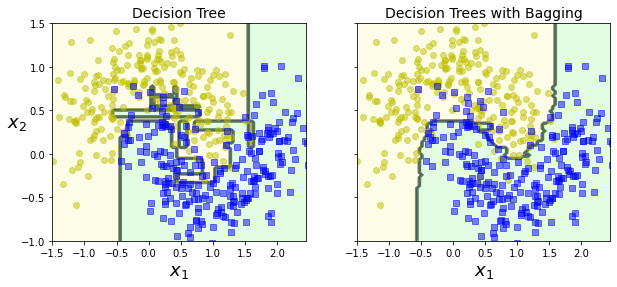

In [ ]:
# Plotting the data points and predictions

## Creating the figure
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

## Plotting Decision Tree
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)

## Plotting Bagging Tree
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")

plt.show()

bootstrapping introduces more diversity in the subsets that each predictor is trained on
* adds higher bias
* predictors end up being less correlated -> reduces variance

#### Out-of-Bag Evaluation
* with bagging, some observations may be sampled several times for any given predictor, while others may not be sampled at all
* only 63% of training observations are sampled on average for each predictor
* the remaining 37% of training observations are out-of-bag (oob) observations
* not the same 37% for all predictors
* oob can be used to evaluate
* ***oob_score=True***

In [ ]:
# Implementing oob evaluation

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), 
    n_estimators=500,
    bootstrap=True,
    n_jobs=-1,
    oob_score=True
)

bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.896

oob evaluation is saying that the bagging classifier is likely to achieve 89.6%

In [ ]:
# Confirming if oob evaulation gives similar accuracy

from sklearn.metrics import accuracy_score

y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.904

## Random Patches and Random Subspaces
* BaggingClassifier supports sampling the features
* ***max_features*** and ***bootstrap_features***

## Random Forests
* instead of searching for the very best feature when splitting a node, it searches the best feature among a random subset of features
* trades a high bias for a low variance
* ensemble of decision trees
* has all hyperparameters of a Decision Tree and Bagging Classifier
* introduces extra randomness


### Extra-Trees
* make trees more randon by also using random thresholds for each feature rather than searching for the best possible thresholds

### Feature Importance
* measures feature importances by looking at how much the tree nodes that use that feature reduce impurity on average
* weighted average, where each node's weight is equal to the number of training samples that are associated with it

In [ ]:
# Viewing the feature importances

## Imports
from sklearn.datasets import load_iris

## Loading the dataset
iris = load_iris()

## Creating RFC object
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)

## Fittign data
rnd_clf.fit(iris['data'], iris['target'])

for name, score in zip(iris['feature_names'], rnd_clf.feature_importances_):
  print(name, score)

sepal length (cm) 0.09602113841843442
sepal width (cm) 0.023931943479120123
petal length (cm) 0.4513171511269271
petal width (cm) 0.4287297669755184


<BarContainer object of 4 artists>

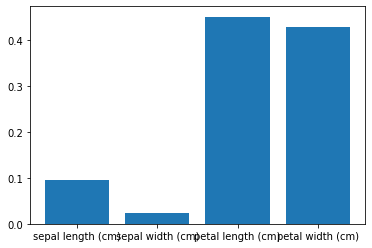

In [ ]:
# Plotting the feature importances

plt.bar(iris['feature_names'], rnd_clf.feature_importances_)

## Boosting
* combines several weak learners into a strong learner
* train predictors sequentially

### AdaBoost
* pays more attention to the training observations that the predecing classifier underfitted
* increases the weights of misclassified training instances

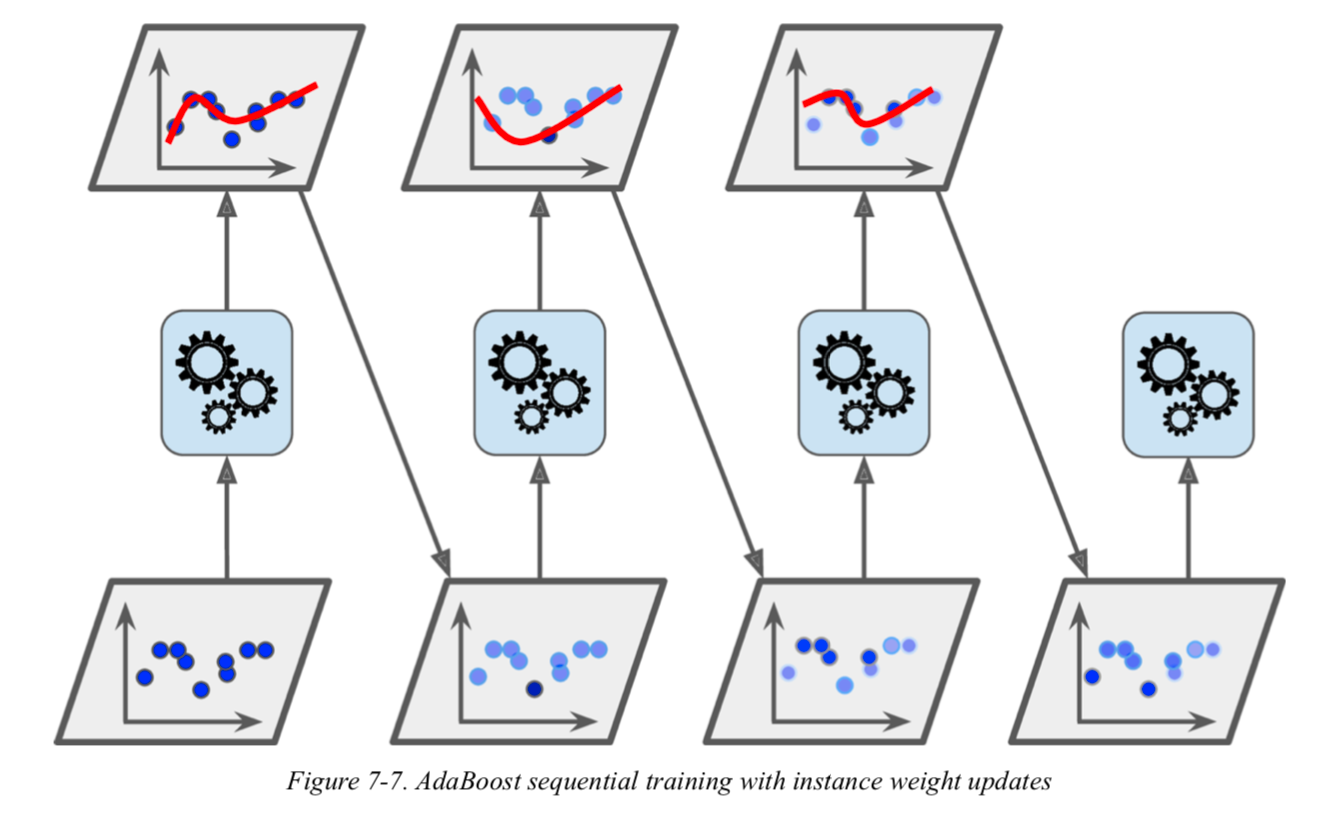

In [ ]:
# Implementing AdaBoost

from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=200,
    algorithm="SAMME.R",
    learning_rate=0.5
)

ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

SAMME:
* Stagewise Additive Modeling using a Multiclass Exponential loss function
* multiclass version of Adaboost

### Gradient Boosting
* sequentially add predictors to an ensemble, each one correcting its predecessor
* tries to fit the new predictor to the residual errors made bt the previous predictor

In [ ]:
# Implementing Gradient Boosting

from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(
    max_depth=2,
    n_estimators=3,
    learning_rate=1.0
)

gbrt.fit(X, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=1.0, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=3,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

***learning_rate*** : scales the contribution of each tree
* regularization technique: shrinkage
* 0.1 -> more trees in ensemble to fit the training data
* decreases variance

To find the optimal number of trees, use early stopping

In [ ]:
# Implementing early stopping on validation set

## Imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

## Splitting data into train and test
X_train, X_val, y_train, y_val = train_test_split(X, y)

## Fitting a GBR
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)

## Collecting errors
errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]

## Getting the best estimator (estimator that provided the least amount of errors)
best_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=best_n_estimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=63,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
# Implementing early stopping on training data

gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)

min_val_error = float('inf')
error_going_up = 0

## Looping through the number of trees
for n_estimators in range(1, 120):
  
  ### Setting the number of trees
  gbrt.n_estimators = n_estimators

  ### Fitting a gbrt with n_estimator
  gbrt.fit(X_train, y_train)
  
  ### Predicting on validation data 
  y_pred = gbrt.predict(X_val)

  ### Calculating mse
  val_error = mean_squared_error(y_val, y_pred)
  
  ### If mse is less than previous, mse is the new minimum 
  if val_error < min_val_error:
    min_val_error = val_error
    error_going_up = 0
  
  ### Else if it is not minimum, increase error_going_up by one
  else:
    error_going_up += 1

    ####  If error_going_up is greater than 5, stop training
    if error_going_up == 5:
      break

Stochastic Gradient Boosting
* randomly selects a subset of training observations to be used for each tree
* trades higher bias for lower variance
* speeds up training

XGBoost (Extreme Gradient Boosting)
* optimized implementation of Gradient Boosting
* fast, scalable, portable

In [ ]:
# Implementing XGBoost
!pip install xgboost

import xgboost

xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(
  X_train, 
  y_train,
  eval_set=[(X_val, y_val)],
  early_stopping_rounds=2
)
y_pred = xgb_reg.predict(X_val)

[15:13:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.46928
Will train until validation_0-rmse hasn't improved in 2 rounds.
[1]	validation_0-rmse:0.442239
[2]	validation_0-rmse:0.419804
[3]	validation_0-rmse:0.401431
[4]	validation_0-rmse:0.384814
[5]	validation_0-rmse:0.371945
[6]	validation_0-rmse:0.360204
[7]	validation_0-rmse:0.351076
[8]	validation_0-rmse:0.34291
[9]	validation_0-rmse:0.333361
[10]	validation_0-rmse:0.327434
[11]	validation_0-rmse:0.320624
[12]	validation_0-rmse:0.316431
[13]	validation_0-rmse:0.311172
[14]	validation_0-rmse:0.307079
[15]	validation_0-rmse:0.303214
[16]	validation_0-rmse:0.299813
[17]	validation_0-rmse:0.296854
[18]	validation_0-rmse:0.294125
[19]	validation_0-rmse:0.290789
[20]	validation_0-rmse:0.288933
[21]	validation_0-rmse:0.286264
[22]	validation_0-rmse:0.285028
[23]	validation_0-rmse:0.284124
[24]	validation_0-rmse:0.282749
[25]	validation_0-rms

## Stacking
* stacking generalization
* using a model to perform agggregation instead of using hard voting


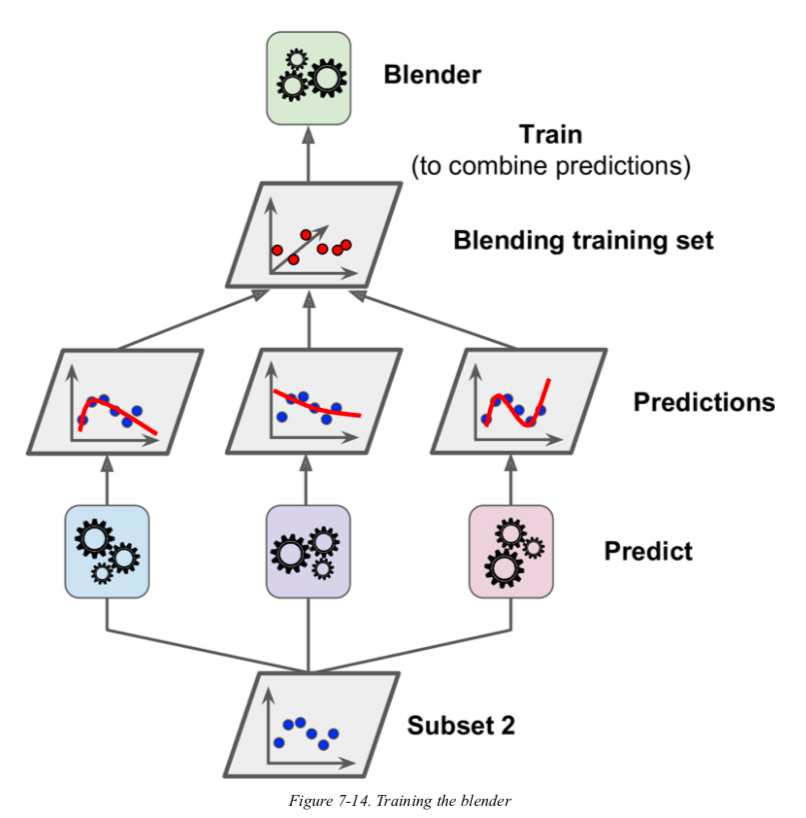